<a href="https://colab.research.google.com/github/bert13069598/Advanced-AI/blob/master/Lecture21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)
batch_size=4
trainset=torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform)
trainloader=torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)
testset=torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader=torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                       shuffle=False, num_workers=2)
classes=('plane','car','bird','cat',
         'deer','dog','frog','horse','ship','truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
print('trainset :',len(trainset))
print('testset :',len(testset))
print(trainset[0][0].size())

trainset : 50000
testset : 10000
torch.Size([3, 32, 32])


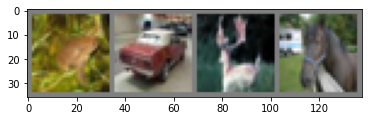

frog  car   deer  horse


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

dataiter = iter(trainloader)
images, labels=next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(3,6,5)
    self.pool=nn.MaxPool2d(2,2)
    self.conv2=nn.Conv2d(6,16,5)
    self.fc1=nn.Linear(16*5*5,120)
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=torch.flatten(x,1)
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=self.fc3(x)
    return x

net=Net()

In [10]:
import torchsummary
torchsummary.summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [12]:
for epoch in range(2):

  running_loss=0.0
  for i,data in enumerate(trainloader, 0):
    inputs, labels=data

    optimizer.zero_grad()

    outputs=net(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()
    if i % 2000 == 1999:
      print(f'[{epoch+1},{i+1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss=0.0

PATH='./cifar_net.pth'
torch.save(net.state_dict(), PATH)

print('Finish Training')

[1, 2000] loss: 2.246
[1, 4000] loss: 1.922
[1, 6000] loss: 1.714
[1, 8000] loss: 1.623
[1,10000] loss: 1.531
[1,12000] loss: 1.506
[2, 2000] loss: 1.411
[2, 4000] loss: 1.409
[2, 6000] loss: 1.347
[2, 8000] loss: 1.321
[2,10000] loss: 1.307
[2,12000] loss: 1.316
Finish Training


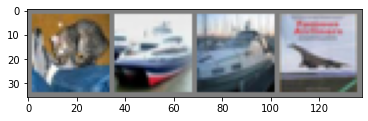

GroundTruth:  cat   ship  ship  plane


In [15]:
dataiter=iter(testloader)
images, labels=next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [16]:
net=Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted=torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  car   plane


In [17]:
correct=0
total=0

with torch.no_grad():
  for data in testloader:
    images, labels=data
    ouputs = net(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
  for data in testloader:
    images, labels=data
    outputs= net(images)
    _,predictions=torch.max(outputs, 1)

    for label, prediction in zip(labels,predictions):
      if label==prediction:
        correct_pred[classes[label]]+=1
      total_pred[classes[label]]+=1
for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class: {classname:5s} is {accuracy:.1f}%')

Accuracy for class: plane is 51.5%
Accuracy for class: car   is 63.3%
Accuracy for class: bird  is 53.3%
Accuracy for class: cat   is 32.3%
Accuracy for class: deer  is 38.0%
Accuracy for class: dog   is 47.5%
Accuracy for class: frog  is 72.1%
Accuracy for class: horse is 66.9%
Accuracy for class: ship  is 58.7%
Accuracy for class: truck is 70.8%
